In [1]:
!mkdir /content/drive/My\ Drive/Distributed/

%cd /content/drive/My\ Drive/Distributed/

mkdir: cannot create directory ‘/content/drive/My Drive/Distributed/’: File exists
/content/drive/My Drive/Distributed


In [18]:
from collections import defaultdict, deque, Counter
import numpy as np
from tqdm import tqdm_notebook as tqdm 
from sklearn.linear_model import LogisticRegression
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import csv
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
import copy
import torch
from torch import nn
import os
import numpy as np
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import torch.optim as optim
import pickle as P
from joblib import dump, load


CACHE_SIZE= 50
LR = 0.001
BATCH_SIZE= 32
EPOCH = 100
PATH1 = "CNN_2layer.pth"
PATH2 = "MLP_2layer.pth"

In [3]:
#@title Default title text
def belady_opt(blocktrace, frame):
    '''
    INPUT
    ============
    blocktrace - list of blocks in sequence of request
    cachesize - int value for capacity of the cache
    
    OUTPUT
    ============
    (1) hitrate (int)
    (2) cache configuration and eviction block at time of miss (np.array)  
    '''
    
    infinite_index = 100 * len(blocktrace) 
    # should be a large integer than block number
    
    block_index = defaultdict(deque) 
    # dictionary with block number as key and list
    # of index value in blocktrace
    
    upcoming_index = defaultdict(int)
    # dictionary with index number as key and value as block
    
    frequency = defaultdict(int)
    # dictionary of block as key and number
    # of times it's been requested so far
    
    recency = list()
    # list of block in order of their request
    
    Cache = deque()
    # Cache with block
    
    dataset = np.array([]).reshape(0,3*frame+1)
    #columns represents the number of block in cache and 
    #3 is the number of features such as frequency, recency and block number
    #+1 is for label 0-1
    
    hit, miss = 0, 0
    
    # populate the block_index
    for i, block in enumerate(blocktrace):
        block_index[block].append(i)
        
    # sequential block requests start
    for i, block in enumerate(blocktrace):
        
        # increament the frequency number for the block
        frequency[block] += 1
        
        # make sure block has the value in block_index dictionary 
        # as current seq_number
        if len(block_index[block]) != 0 and block_index[block][0] == i:
            
            # if yes, remove the first element of block_index[block]
            block_index[block].popleft()
        
        # if block exist in current cache
        if block in Cache:
            
            # increment hit
            hit += 1
            
            # update the recency
            recency.remove(block)
            recency.append(block)
            
            # update upcoming_index
            if i in upcoming_index:
                
                # delete old index
                del upcoming_index[i]
        
                if len(block_index[block]) is not 0:
                    # add new upcoming index
                    upcoming_index[block_index[block][0]] = block
                    # remove index from block_index
                    block_index[block].popleft()
                else:
                    # add a large integer as index
                    upcoming_index[infinite_index] = block
                    # increament large integer
                    infinite_index-=1
           
        # block not in current cache
        else:
            
            # increament miss
            miss += 1
            
            # if cache has no free space
            if len(Cache) == frame:
                  
                # find the farthest i.e. max_index in upcoming_index
                max_index = max(upcoming_index)

                if (i % 10 +1 == 10):
                    blockNo = np.array([i for i in Cache])
                    blockNo = blockNo / np.linalg.norm(blockNo)
                    recency_ = np.array([recency.index(i) for i in Cache])
                    recency_ = recency_ / np.linalg.norm(recency_)
                    frequency_ = np.array([frequency[i] for i in Cache])
                    frequency_ = frequency_ / np.linalg.norm(frequency_)
                    stack = np.column_stack((blockNo, recency_, frequency_)).reshape(1,frame*3)
                    stack = np.append(stack, Cache.index(upcoming_index[max_index]))
                    dataset = np.vstack((dataset, stack))
                # remove the block with max_index from cache
                Cache[Cache.index(upcoming_index[max_index])] = block

                # remove the block with max_index from recency dict
                recency.remove(upcoming_index[max_index])

                # remove max_index element from upcoming_index
                del upcoming_index[max_index]
                    
            
            else:
                 
                # add block into Cache
                Cache.append(block)

            # add block into recency
            recency.append(block)
                
            # add upcoming request of current block in upcoming_index
            if len(block_index[block]) != 0:
                
                # add upcoming index of block
                upcoming_index[block_index[block][0]] = block
               
                # remove the index from block_index 
                block_index[block].popleft()
            
            else:
                
                # add a large integer as index
                upcoming_index[infinite_index] = block
                
                # increament high number
                infinite_index -= 1
 
            
    # calculate hitrate
    hitrate = hit / (hit + miss)

    return hitrate, dataset

In [4]:
def LFU (blocktrace, cache_size):
    cache = set()
    cache_frequency = defaultdict(int)
    frequency = defaultdict(int)

    hit, miss = 0, 0

    for block in tqdm(blocktrace, disable=True):
        frequency[block] += 1

        if block in cache:
            hit += 1
            cache_frequency[block] += 1

        elif len(cache) < cache_size:
            cache.add(block)
            cache_frequency[block] += 1
            miss += 1

        else:
            e, f = min(cache_frequency.items(), key=lambda a: a[1])
            cache_frequency.pop(e)
            cache.remove(e)
            cache.add(block)
            cache_frequency[block] = frequency[block]
            miss += 1

    hitrate = hit / (hit + miss)
    return hitrate

In [5]:
def LRU( blocktrace, cache_size):

    cache = set()
    recency = deque()
    hit, miss = 0, 0

    for block in tqdm(blocktrace, disable=True):

        if block in cache:
            recency.remove(block)
            recency.append(block)
            hit += 1

        elif len(cache) < cache_size:
            cache.add(block)
            recency.append(block)
            miss += 1

        else:
            cache.remove(recency[0])
            recency.popleft()
            cache.add(block)
            recency.append(block)
            miss += 1

    hitrate = hit / (hit + miss)
    return hitrate

In [6]:
class LeCarLruLfu:

    def __init__(self, learning_rate=0.45, discount_rate=0.005, cache_size=100):
        self.learning_rate = learning_rate
        # self.discount_rate=discount_rate ** (1/cache_size)
        self.discount_rate = discount_rate
        self.cache_size = cache_size
        self.weight_lru = 0.5
        self.weight_lfu = 0.5

        self.history_size = self.cache_size * 1
        self.cache = set()
        self.page_timestamp = dict()
        self.history_lru = deque()
        self.history_lfu = deque()
        self.global_frequency = defaultdict(int)

        self.recency = deque()
        self.cache_frequency = defaultdict(int)
        self.frequency = defaultdict(int)

        self.page_time = dict()

        print("LeCarLruLfu: learning_rate:" + str(self.learning_rate) + " discount_rate:" + str(
            discount_rate) + "," + str(self.discount_rate) + " cache_size:" + str(self.cache_size))

    def run_algorithm(self, blocktrace: list, timestamp: list):
        size = len(blocktrace)

        hit, miss = 0, 0
        lru_miss = 0
        lfu_miss = 0
        total_lru_time = 0
        total_lfu_time = 0
        last_miss = 0
        for i, block in enumerate(tqdm(blocktrace, disable=True)):
            '''if i %1000==0:
                #    print(str(i)+"/"+str(size)+":"+str(round(i/size,2))+" time:"+str(datetime.datetime.now()-start_time))
                    print("reward:"+str(reward_lru)+","+str(reward_lfu))
                    print("weight:"+str(self.weight_lru)+","+str(self.weight_lfu))
             '''
            self.frequency[block] += 1
            if block in self.cache:
                self.update_block(block)
                hit += 1
            else:
                '''
                if block in self.page_timestamp:
                    time_spend_in_millis=self.millis(timestamp[i])-self.page_timestamp[block]
                else:
                    time_spend_in_millis=1'''
                if block in self.history_lru or block in self.history_lfu:
                    time_spend = i - self.page_time[block]

                    if time_spend > miss - last_miss:
                        if block in self.history_lru:
                            self.history_lru.remove(block)
                        if block in self.history_lfu:
                            self.history_lfu.remove(block)
                        last_miss = miss

                # if self.reward_lru != 1 and self.reward_lfu !=1:
                #    print("before reward:"+str(self.reward_lru)+","+str(self.reward_lfu))
                reward_lru = 0
                reward_lfu = 0

                if block in self.history_lru:
                    self.history_lru.remove(block)
                    reward_lfu = self.discount_rate ** time_spend
                    '''self.weight_lfu=self.weight_lfu* np.exp(self.learning_rate*reward_lfu)
                    self.weight_lru=self.weight_lru/(self.weight_lfu+self.weight_lru)
                    self.weight_lfu=1-self.weight_lru'''
                    self.update_weight(reward_lru, reward_lfu)
                    lru_miss += 1
                    total_lru_time += time_spend

                if block in self.history_lfu:
                    self.history_lfu.remove(block)
                    reward_lru = self.discount_rate ** time_spend
                    '''self.weight_lru=self.weight_lru* np.exp(self.learning_rate*reward_lru)
                    self.weight_lru=self.weight_lru/(self.weight_lfu+self.weight_lru)
                    self.weight_lfu=1-self.weight_lru'''
                    self.update_weight(reward_lru, reward_lfu)
                    lfu_miss += 1
                    total_lfu_time += time_spend

                if len(self.cache) == self.cache_size:
                    victim = self.evcitPage(block)
                    self.cache.remove(victim)
                    self.remove_block(victim)
                self.cache.add(block)
                self.add_block(block)
                # self.page_timestamp[block]=self.millis(timestamp[i])
                miss += 1
            self.page_time[block] = i

        print("weight:" + str(self.weight_lru) + "," + str(self.weight_lfu))
        print("lru_miss:" + str(lru_miss) + " lfu_miss:" + str(lfu_miss) + " total miss:" + str(miss))
        print("total_time_lru:" + str(total_lru_time) + " total_time_lfu:" + str(total_lfu_time))
        # print("avg lru time:" + str(total_lru_time / lru_miss) + " avg lfu time:" + str(total_lfu_time / lfu_miss))

        return hit / (hit + miss)

    def update_weight(self, reward_lru, reward_lfu):
        # if self.reward_lru != 1 or self.reward_lfu !=1:

        # print("before reward:"+str(self.reward_lru)+","+str(self.reward_lfu))
        self.weight_lfu = self.weight_lfu * np.exp(self.learning_rate * reward_lfu)
        self.weight_lru = self.weight_lru * np.exp(self.learning_rate * reward_lru)
        self.weight_lru = self.weight_lru / (self.weight_lfu + self.weight_lru)
        self.weight_lfu = 1 - self.weight_lru
        # if self.reward_lru != 1 or self.reward_lfu !=1:
        #    print("after:"+str(self.weight_lru)+","+str(self.weight_lfu))
        # print("after reward:"+str(self.reward_lru)+","+str(self.reward_lfu))

    def millis(self, my_time):
        return int(round(my_time * 1000))

    def chooseRandom(self):
        r = np.random.rand()
        if r < self.weight_lru:
            return 0
        return 1

    def evcitPage(self, block):
        policy = self.chooseRandom()
        if policy == 0:
            victim = self.recency[0]
            if len(self.history_lru) == self.history_size:
                self.history_lru.popleft()
            self.history_lru.append(victim)
        else:
            victim, f = min(self.cache_frequency.items(), key=lambda a: a[1])
            if len(self.history_lfu) == self.history_size:
                self.history_lfu.popleft()
            self.history_lfu.append(victim)
        return victim

    def update_block(self, block):
        self.cache_frequency[block] += 1
        self.recency.remove(block)
        self.recency.append(block)

    def remove_block(self, block):
        self.recency.remove(block)
        self.cache_frequency.pop(block)

    def add_block(self, block):
        self.recency.append(block)
        self.cache_frequency[block] = self.frequency[block]

In [16]:
import torch
from torch import nn
import numpy as np
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

device = torch.device("cuda:0" if torch.cuda.is_available else "cpu")

# class CNN1(nn.Module):
#     def __init__(self):
#         super(CNN1, self).__init__()
#         self.dropout = nn.Dropout(0.5)
#         self.out = nn.Sequential(
#             nn.Linear(900,1000),
#             # nn.ReLU(),
#             # nn.Linear(1800,1000),
#             nn.ReLU(),
#             nn.Linear(1000,CACHE_SIZE)
#             )
#     def forward(self, x):
#         # x = self.conv1(x.unsqueeze(1))
#         # x = self.conv2(x)
#         # x = x.view(x.size(0), -1)           # flatten the output of conv2 to (batch_size, 32 * 7 * 7)
#         output = self.out(x)
#         return output

class CNN2(nn.Module):
    def __init__(self):
        super(CNN2, self).__init__()
        self.dropout = nn.Dropout(0.5)
        self.layer1 = nn.Sequential(nn.Conv2d(
            in_channels = 1,
            out_channels = 4,
            kernel_size = (7,1),
            stride = 1,
            padding =0),
        nn.ReLU(),
        self.dropout
        )
        self.layer2 = nn.Sequential(nn.Conv2d(
            in_channels = 4,
            out_channels = 8,
            kernel_size = (7,3),
            stride = 1,
            padding =0
            ),
        nn.ReLU(),
        self.dropout
        )
        self.fc = nn.Sequential( #704 for cachesize=100, 304 for 50
            nn.Linear(304, 256)
            )
        self.out = nn.Sequential(
            nn.Linear(256, CACHE_SIZE)
        )

    def forward(self, x):
        # print(x.shape)
        x = self.layer1(x.view(-1, 1, CACHE_SIZE, 3))
        x = self.layer2(x)
        x = x.view(x.size(0), -1)
        # print(x.shape)
        x = self.fc(x)
        output = self.out(x)
        return output



In [8]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(         # input shape (1, CACHE_SIZE, 2)
            nn.Conv2d(
                in_channels=1,              # input height
                out_channels=5,            # n_filters
                kernel_size=(5,3),              # filter size
                stride=1,                   # filter movement/step
                padding=0,                  # if want same width and length of this image after Conv2d, padding=(kernel_size-1)/2 if stride=1
            ),                              # output shape (16, 28, 28)
            nn.ReLU(),                      # activation
        )
        self.conv2 = nn.Sequential(         # input shape (16, 14, 14)
            nn.Conv2d(  
                in_channels=5,              # input height
                out_channels=10,            # n_filters
                kernel_size=3,              # filter size
                stride=1,                   # filter movement/step
                padding=2),    # output shape (32, 14, 14)
            nn.ReLU(),                      # activation
        )
        self.out = nn.Sequential(
            nn.Linear(2940,1000),
            nn.Linear(1000,CACHE_SIZE)
            )
        self.linear = nn.Sequential(
            nn.Linear(3,10),
            nn.ReLU(),
            nn.Linear(10,100),
            nn.ReLU(),
            nn.Linear(100,1000),
            nn.ReLU(),
            nn.Linear(1000,500),
            nn.ReLU(),
            nn.Linear(500,CACHE_SIZE)
            )
    def forward(self, x):
        # x = self.conv1(x.unsqueeze(1))
        # x = self.conv2(x)
        # x = x.view(x.size(0), -1)           # flatten the output of conv2 to (batch_size, 32 * 7 * 7)
        # output = self.out(x)
        output = self.linear(x.view(-1, 1, CACHE_SIZE, 3))
        return output

In [9]:

class LoadDataset(Dataset):
  def __init__(self, x, y):
    self.x = x
    self.y = y
  def __getitem__(self, item):
    feature = self.x[item]
    feature = feature.reshape(CACHE_SIZE, 3);
    label = self.y[item]
    return feature, label

  def __len__(self):
    return len(self.x)



def train(dataset, model, path):
    train_data, val_data = train_test_split(dataset,test_size=0.1, random_state=None, shuffle=True)
    trainset = LoadDataset(x=train_data[:,:-1], y=train_data[:, -1])
    validset = LoadDataset(x=val_data[:,:-1], y=val_data[:, -1])

    train_loader = DataLoader(trainset, batch_size = BATCH_SIZE, shuffle=True, num_workers=4)
    val_loader = DataLoader(validset, batch_size= BATCH_SIZE, shuffle=False, num_workers=2)
    lossplt =[]
    epochplt=[]
    valplt = []

    pre_acc = 0.0
    best_model = None
    best_epoch =0
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=LR)
    # schedular = optim.lr_scheduler.MultiplicativeLR(optimizer, lr_lambda= lambda epoch: 0.1)
    
    for epoch in range(0,EPOCH):
        running_loss = 0.0
        i=0
        for train_X, train_Y in train_loader:
            inputs, labels = train_X.to(device), train_Y.to(device)
            optimizer.zero_grad()
            
            outputs = model.forward(inputs.float())
            loss = criterion(outputs, labels.long())
            loss.backward()

            optimizer.step()
            # if(epoch%10 == 0):
            #     schedular.step()
        
            running_loss += loss.item()

        lossplt.append(running_loss)
        epochplt.append(epoch)
        
        with torch.no_grad():
            running_loss_val =0.0
            for val_X, val_Y in val_loader:
                inputs, labels = val_X.to(device), val_Y.to(device)
                optimizer.zero_grad()
                
                outputs = model.forward(inputs.float())
                loss = criterion(outputs, labels.long())
                running_loss_val += loss.item()
            
            valplt.append(running_loss_val)
        acc,_,_ = predict(val_data, model)
        print('[%d] Training loss: %3f' %(epoch+1, running_loss/len(train_data)),
              ' [%d] Validation loss: %3f' %(epoch+1, running_loss_val/len(val_data)), ' With Validation Accuracy: %3f' %(acc))
        
        if(acc > pre_acc):
            best_model = copy.deepcopy(model)
            best_epoch = epoch
            pre_acc = acc

    print("Best model found at epoch ", best_epoch)
    torch.save(best_model.state_dict(), path)
    plt.plot(epochplt, lossplt)
    plt.ylim([0, max(lossplt)+1])
    plt.xlim([0, EPOCH+1])
    plt.xlabel('Epochs')
    plt.ylabel('loss')
    plt.savefig('plot.png')


def predict(test_data, model, device='cuda'):
    # print(test_data.shape)
    total =0
    correct =0
    pred_labels = []
    orig_labels = []
    testset = LoadDataset(x=test_data[:,:-1], y=test_data[:, -1])
    test_loader= DataLoader(testset, batch_size=4, shuffle=False, num_workers=1)
    print(device)
    with torch.no_grad():
        for test_data, test_label in test_loader:
            if device == 'cpu':
                inputs, labels = test_data, test_label
            else:
                inputs, labels = test_data.to(device), test_label.to(device)
            outputs = model(inputs.float())
            _, predicted = torch.max(F.softmax(outputs.data), 1)
            total += labels.size(0)
            correct += (predicted==labels).sum().item()
            if device == 'cpu':
                predicted = predicted.numpy().flatten()
                labels = labels.numpy()
            pred_labels.append(predicted)
            orig_labels.append(labels)
    return correct/total, pred_labels, orig_labels

In [23]:
def hitRate(blocktrace, frame, model, model_type='CNN'):
    '''
    INPUT
    ==========
    blocktrace = list of block request sequence
    frame = size of the cache
    
    OUTPUT
    ==========
    hitrate 
    '''
    
    frequency = defaultdict(int)
    # dictionary of block as key and number
    # of times it's been requested so far
    
    recency = list()
    # list of block in order of their request
    
    Cache = []
    # Cache with block
    
    hit, miss = 0, 0
    
    
    # sequential block requests start
    for i, block in enumerate(blocktrace):
        # increament the frequency number for the block
        frequency[block] += 1
        
        # if block exist in current cache
        if block in Cache:
            
            # increment hit
            hit += 1
            
            # update the recency
            recency.remove(block)
            recency.append(block)
            
        # block not in current cache
        else:
            
            # increament miss
            miss += 1
            
            # if cache has no free space
            if len(Cache) == frame:  
                blockNo = np.array([i for i in Cache])
                blockNo = blockNo / np.linalg.norm(blockNo)
                recency_ = np.array([recency.index(i) for i in Cache])
                recency_ = recency_ / np.linalg.norm(recency_)
                frequency_ = np.array([frequency[i] for i in Cache])
                frequency_ = frequency_ / np.linalg.norm(frequency_)
                stack = np.column_stack((blockNo, recency_, frequency_)).reshape(1,frame*3)
                if(model_type=='CNN'):
                    index = model(torch.FloatTensor(stack))
                    pred = np.argsort(F.softmax(index.data[0]).numpy())[-1]
                else:
                    # print(stack.shape)
                    pred = int(model.predict(stack)[0])
                    # print(pred)
                # print(pred)
                evict_block = Cache[pred]
                # remove the block with max_index from cache
                Cache[Cache.index(evict_block)] = block

                # remove the block with max_index from recency dict
                recency.remove(evict_block)
            else:
                # add block into Cache
                Cache.append(block) 
            
            # add block into recency
            recency.append(block)  
    # calculate hitrate
    hitrate = hit / (hit + miss)

    return hitrate

In [11]:
# if __name__ == '__main__':
# 	filename = "0.csv"
# 	blocktrace = []
# 	timestamp = []
# 	with open(filename) as f:
# 		csv_reader = csv.reader(f, delimiter =",")
# 		for row in csv_reader:
# 			blocktrace.append(int(row[1]))
# 			timestamp.append(int(row[0]))

# 	hr, dataset = belady_opt(blocktrace, CACHE_SIZE) #0.29212333333333335
# 	outfile = open('blocktrace', 'wb')
# 	P.dump(blocktrace,outfile)
# 	outfile.close()
# 	outfile = open('timestamp', 'wb')
# 	P.dump(timestamp,outfile)
# 	outfile.close()
# 	print(hr)
# 	print("blocktrace, timestamp are imported")
# 	# wfilename = "data_interval10000.csv"
# 	# with open(wfilename, 'w', newline='') as f:
# 	# 	for data in dataset:
# 	# 		csv_writer = csv.writer(f, delimiter =",")
# 	# 		csv_writer.writerow(data)


# # 	# dataset = np.array([]).reshape(0,3*CACHE_SIZE+1)
# # 	# with open("data_interval10.csv") as f:
# # 	# 	csv_reader = csv.reader(f, delimiter =",")
# # 	# 	i =0
# # 	# 	for row in csv_reader:
# # 	# 		# r = []
# # 	# 		# for i in range(0,901):
# # 	# 		# 	r.append(float(row[i]))
# # 	# 		row[900] = int(float(row[900]))
# # 	# 		dataset = np.vstack((dataset, row))
# # 	# 		if(i%1000+1==1000):
# # 	# 			print(i, " iterations done")
# # 	# 		i += 1
# 	outfile = open('data_interval100', "wb")
# 	P.dump(dataset,outfile)
# 	outfile.close()

(5483, 151)


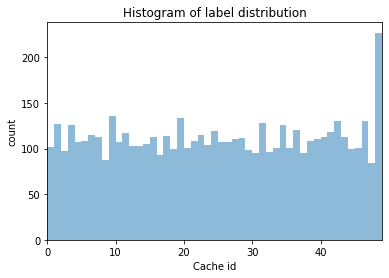

[17. 18.  2. 44. 27. 19. 19. 49. 19. 32. 23. 18. 26.  9. 33. 40. 27.  7.
  5. 44.]
(5483, 151)
cuda


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:101: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


[1] Training loss: 0.122957  [1] Validation loss: 0.128425  With Validation Accuracy: 0.009107
cuda
[2] Training loss: 0.122767  [2] Validation loss: 0.128484  With Validation Accuracy: 0.007286
cuda
[3] Training loss: 0.122510  [3] Validation loss: 0.128047  With Validation Accuracy: 0.020036
cuda
[4] Training loss: 0.120357  [4] Validation loss: 0.125631  With Validation Accuracy: 0.056466
cuda
[5] Training loss: 0.116546  [5] Validation loss: 0.122384  With Validation Accuracy: 0.071038
cuda
[6] Training loss: 0.115124  [6] Validation loss: 0.123061  With Validation Accuracy: 0.072860
cuda
[7] Training loss: 0.113719  [7] Validation loss: 0.120655  With Validation Accuracy: 0.081967
cuda
[8] Training loss: 0.112919  [8] Validation loss: 0.122113  With Validation Accuracy: 0.076503
cuda
[9] Training loss: 0.111638  [9] Validation loss: 0.120246  With Validation Accuracy: 0.083789
cuda
[10] Training loss: 0.111700  [10] Validation loss: 0.119963  With Validation Accuracy: 0.069217
cud

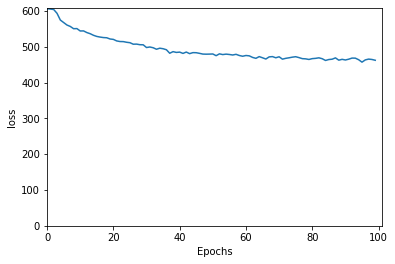

In [19]:


datablk = "data/finaltrain2/0.csv" #cheetah.cs.fiu.edu-110108-113008.2.blkparse"

df = pd.read_csv(datablk, sep =',')
# print(df.head().T)
# df = df.iloc[1:]
# print(df.head().T)
# df= df.str.split(" ",  expand = True) 
# df.columns = ['timestamp','pid','pname','blockNo',
#               'blockSize', 'readOrWrite', 'bdMajor', 'bdMinor', 'hash']

df.columns = ['timestamp','blockNo', 'data', 'readOrWrite']

blocktrace = df['blockNo'].tolist()

timestamp = df['timestamp'].tolist()


infile = open('csvblocktrace_train','wb')
P.dump(blocktrace, infile)
infile.close()

infile = open('csvtimestamp_train','wb')
P.dump(timestamp, infile)
infile.close() 

hr, dataset = belady_opt(blocktrace, CACHE_SIZE)  #0.05295678027763743
outfile = open('datacsv_train', "wb")
P.dump(dataset,outfile)
outfile.close()
infile = open('csvblocktrace_train','rb')
blocktrace = P.load(infile)
infile.close()

infile = open('csvtimestamp_train','rb')
timestamp = P.load(infile)
infile.close() 

infile = open('datacsv_train','rb')
dataset = P.load(infile)
infile.close() 

print(dataset.shape)

# print(dataset[0])
X_train = dataset
bins = np.arange(0, CACHE_SIZE, 1)
Y_train = X_train[:,-1]
plt.xlim([min(Y_train), max(Y_train)])
plt.hist(Y_train, bins=bins, alpha=0.5)
plt.title('Histogram of label distribution')
plt.xlabel('Cache id')
plt.ylabel('count')
plt.show()

print(Y_train[:20])
#Train and test the model
print(X_train.shape)

train_data = X_train 
model = CNN2()
model.to(device)
PATH = "CNN_2_1layer_10.pth"
train(train_data, model, PATH)

acc_train, _, _ = predict(train_data, model)
print('Accuracy of CNN classifier on train set: {:.2f}'.format(acc_train))


# model2 = CNN()
# model2.to(device)
# PATH2 = "MLP_2layer.pth"
# train(train_data, model2, PATH2)


# model2 = CNN()
# model2.load_state_dict(torch.load(PATH2))
# model2.eval()
# acc_test, pred_labels, orig_labels = predict(test_data, model2)
# acc_train, _, _ = predict(train_data, model2)
# print('Accuracy of MLP classifier on test set: {:.2f}'.format(acc_test))
# print('Accuracy of MLP classifier on train set: {:.2f}'.format(acc_train))






In [20]:
NN = MLPClassifier(hidden_layer_sizes=(500, ), activation='tanh', batch_size=64, random_state=1, max_iter=500)
NN.fit(X_train[:, :-1], Y_train)

dump(NN, 'MLP_10.joblib') 

['MLP_10.joblib']

In [21]:
logreg = LogisticRegression(max_iter = 10000)
logreg.fit(X_train[:,:-1], Y_train)

dump(logreg, 'LR_10.joblib') 

['LR_10.joblib']

In [24]:
datablk = "data/finaltest2/0.csv" #cheetah.cs.fiu.edu-110108-113008.2.blkparse"
df = pd.read_csv(datablk, sep =',')
df.columns = ['timestamp','blockNo', 'data', 'readOrWrite']

blocktrace_test = df['blockNo'].tolist()

timestamp_test = df['timestamp'].tolist()


infile = open('csvblocktrace_test','wb')
P.dump(blocktrace_test, infile)
infile.close()

infile = open('csvtimestamp_test','wb')
P.dump(timestamp_test, infile)
infile.close() 

hr_test, dataset_test = belady_opt(blocktrace_test, CACHE_SIZE)  #0.05295678027763743
outfile = open('datacsv_test', "wb")
P.dump(dataset_test,outfile)
outfile.close()
infile = open('csvblocktrace_test','rb')
blocktrace_test = P.load(infile)
infile.close()

infile = open('csvtimestamp_test','rb')
timestamp_test = P.load(infile)
infile.close() 

infile = open('datacsv_test','rb')
dataset_test = P.load(infile)
infile.close() 


X_test = dataset_test
Y_test = X_test[:,-1]

#hitrate Computation
model = CNN2()
model.eval()
# model.to(device)
model.load_state_dict(torch.load(PATH))

acc_test, pred_labels, orig_labels = predict(X_test, model, device='cpu')
print('Accuracy of CNN classifier on test set: {:.2f}'.format(acc_test))

print(hr_test)
model.load_state_dict(torch.load(PATH, map_location='cpu'))
hr_CNN = hitRate(blocktrace, CACHE_SIZE, model) #0.33
print('Hitrate CNN classifier workload: {:.2f}'.format(hr_CNN))

cpu


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:101: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Accuracy of CNN classifier on test set: 0.33
0.44914491449144917


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:58: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Hitrate CNN classifier workload: 0.21


In [26]:
MLP = load('MLP_10.joblib')
print('MLP Score: ',MLP.score(X_test[:,:-1], Y_test))

hitRate(blocktrace_test, CACHE_SIZE, MLP, model_type='MLP')

MLP Score:  0.22735674676524953


0.2528252825282528

In [27]:
LReg = load('LR_10.joblib')
print('LR Score: ',LReg.score(X_test[:,:-1], Y_test))

hitRate(blocktrace_test, CACHE_SIZE, LReg, model_type='LR')

LR Score:  0.2033271719038817


0.25032503250325033

In [28]:
print(LRU(blocktrace_test, CACHE_SIZE)) #0.2846284628462846
print(LFU(blocktrace_test, CACHE_SIZE)) #0.4215421542154215
LeCar = LeCarLruLfu(cache_size=CACHE_SIZE) 
print(LeCar.run_algorithm(blocktrace_test, timestamp_test)) #0.3256325632563256

0.15351535153515353
0.3248324832483248
LeCarLruLfu: learning_rate:0.45 discount_rate:0.005,0.005 cache_size:50
weight:0.5000000141328125,0.4999999858671875
lru_miss:5 lfu_miss:6 total miss:8014
total_time_lru:374 total_time_lfu:164
0.19851985198519853


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:36: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


In [ ]:
# print(LRU(blocktrace, CACHE_SIZE)) #0.04229397072599403
# print(LFU(blocktrace, CACHE_SIZE)) #0.04168193991750793
# LeCar = LeCarLruLfu(cache_size=CACHE_SIZE) 
# print(LeCar.run_algorithm(blocktrace, timestamp)) #0.04256559792437897

In [ ]:
eviction = int(0.2*100)
def hitRate2(blocktrace, frame, model):
    LFUDict = defaultdict(int)
    LRUQ = []
#     CacheTS = defaultdict(int)
#     CachePID = defaultdict(int)

    hit, miss = 0, 0

    C = []
    evictCacheIndex = np.array([])
    #count=0
    #seq_number = 0
    for seq_number, block in enumerate(tqdm(blocktrace, desc="OPT")):
        #print(len(evictCacheIndex))
        LFUDict[block] +=1
        #CacheTS[blocktrace[seq_number]] = timestamp[seq_number]
        #CachePID[blocktrace[seq_number]] = pid[seq_number]
        if block in C:
            hit+=1
#             if C.index(block) in evictCacheIndex:
#                 np.delete(evictCacheIndex, C.index(block))
                
            LRUQ.remove(block)
            LRUQ.append(block)
        else:
            evictPos = -1
            miss+=1
            if len(C) == frame:
                if len(evictCacheIndex) == 0: # call eviction candidates
                    #X_test = getX(LRUQ, LFUDict, C)
                    #X_test = getX(LRUQ, LFUDict, C, CacheTS, CachePID)
                    blockNo = C / np.linalg.norm(C)
                    recency_ = np.array([LRUQ.index(i) for i in C])
                    recency_ = recency_ / np.linalg.norm(recency_)
                    frequency_ = np.array([LFUDict[i] for i in C])
                    frequency_ = frequency_ / np.linalg.norm(frequency_)
                    stack = np.column_stack((blockNo, recency_, frequency_)).reshape(1,frame*3)
                    #X_current = model.predict(stack)[0]
                    index = model(torch.FloatTensor(stack))
                    Y_pred_prob = F.softmax(index.data[0]).numpy()
                    # Y_pred_prob = model.predict_proba(stack) #sklearn
                    evictCacheIndex = Y_pred_prob.argsort()[::-1][:eviction]
                    # index of cache blocks that should be removed
                    #return Y_pred_prob, evictCacheIndex
                # evict from cache
                evictPos = evictCacheIndex[0]
                evictBlock = C[evictPos]
                LRUQ.remove(evictBlock)
                #del CacheTS [evictBlock]
                #del CachePID [evictBlock]
            if evictPos is -1:
                C.append(block)
            else:
                C[evictPos] = block
                evictCacheIndex = np.delete(evictCacheIndex, 0)
            LRUQ.append(block)
            #CacheTS [blocktrace[seq_number]] = timestamp[seq_number]
            #CachePID [blocktrace[seq_number]] = pid[seq_number]
        #seq_number += 1

    hitrate = hit / (hit + miss)
    print(hitrate)
    return hitrate

hitRate2(blocktrace_test, 100, model)